## Importing Libraries

In [1]:
from tqdm import tqdm
import zipfile
import os
import json
import spacy
import re
from collections import Counter
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
from prettytable import PrettyTable
import nltk

In [2]:
# loading pre-trained en model from spacy
nlp = spacy.load("en_core_web_sm")


## Loading the data

In [3]:
file_path = '/kaggle/input/pdf-json/pdf_json'

file_names = []
for dirpath, dirnames, filenames in os.walk(file_path):
    for filename in filenames:
        file_names.append(os.path.join(dirpath, filename))
print(len(file_names))
        
file_names = [i for i in file_names if i.endswith('.json')]

56529


In [4]:
len(file_names)

56528

## Helper Function

In [5]:
# Extract text from json file

def json2text(filename):
  file = open(filename)
  content = json.load(file)

  abstract = ''
  body_text = ''
  title = ''

  paper_id = content['paper_id']

  if 'title' in content:
    title = content['title']

  if 'abstract' in content:
    for abs in content["abstract"]:
      abstract = abstract + abs["text"]

  if "body_text" in content:
    for bt in content["body_text"]:
      body_text = body_text + bt["text"]

    return ((f"{title} {abstract} {body_text}").lower())

### Preprocessing

In [6]:
# Function to check if a token is a Roman numeral
def is_roman_numeral(token):
    pattern = r'^(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})$'
    return re.fullmatch(pattern, token) is not None

# Combined preprocessing and cleaning function
def preprocessing(text):
    # Parse the text using spaCy
    doc = nlp(text)
    # Initialize an empty list to hold the filtered tokens
    filt_text = []

    for token in doc:
        # Remove numeric tokens
        if token.like_num:
            continue

        # Select only tokens containing alphabets
        if not token.is_alpha:
            continue

        # Remove stopwords
        if token.is_stop:
            continue

        # Remove Roman numerals
        if is_roman_numeral(token.text):
            continue

        # Remove if token length < 3
        if len(token.text) < 3:
            continue


        if token.text.lower() in ['et', 'al']:
          continue
        # Convert token text to lowercase and add to filtered list
        filt_text.append(token.text.lower())

    return filt_text


In [7]:
# Function to find weighted frequency of each words
def weighted_freq_words(text):

  word_frequencies = Counter(text)

    # Find the maximum frequency in the text
  total_freq = sum(word_frequencies.values())
    # Compute the weighted frequency for each word
  weighted_frequencies = {word: freq / total_freq for word, freq in word_frequencies.items()}
  # sorting the weighted_frequencies in descending order of values
  weighted_frequencies = dict(sorted(weighted_frequencies.items(), key=lambda item: item[1], reverse=True))
  return word_frequencies, weighted_frequencies

In [8]:
# Function to compute Zipf's Law
def compute_zipf_law(word_frequencies):
    sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)
    ranks = np.arange(1, len(sorted_words) + 1)
    frequencies = np.array([freq for word, freq in sorted_words])

    log_ranks = np.log(ranks)
    log_frequencies = np.log(frequencies)
    slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_frequencies)
    alpha = -slope
    return alpha, ranks, sorted_words



In [9]:
# Function to get tokens and vocabulary
def get_tokens_and_vocabulary(processed_text):
    num_tokens = len(processed_text)
    vocabulary = set(processed_text)
    vocab_size = len(vocabulary)
    return num_tokens, vocabulary, vocab_size

In [10]:
# Function to plot Heaps' Law
def plot_heaps_law(processed_text, num_tokens):
    token_counts = []
    vocab_sizes = []
    chunk_size = 10000
    current_vocab = set()

    for i in tqdm(range(0, num_tokens, chunk_size), desc="Plotting Heaps' Law"):
        chunk = processed_text[i:i+chunk_size]
        current_vocab.update(chunk)
        token_counts.append(i + chunk_size)
        vocab_sizes.append(len(current_vocab))

    plt.figure(figsize=(10, 6))
    plt.plot(token_counts, vocab_sizes, label="Vocabulary Growth")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Tokens (log scale)")
    plt.ylabel("Vocabulary Size (log scale)")
    plt.title("Heaps' Law: Tokens vs. Vocabulary")
    plt.legend()
    plt.grid(False)
    plt.show()

## Multiprocessing

In [11]:
cpu_count = os.cpu_count() or mp.cpu_count()
cpu_count

4

In [12]:
# loading pre-trained en model from spacy(Switching to larger model in production)
nlp = spacy.load("en_core_web_sm")

nlp.max_length = 10000000

In [13]:

# Function to process a single file
def process_file(file):
    text = json2text(file)
    processed_txt = preprocessing(text)
    return processed_txt

# Function to parallelize the processing of files and aggregate the results into a corpus
def parallel_process_corpus(json_files):

    with Pool(processes=cpu_count) as pool:
        processed_texts = list(tqdm(pool.imap(process_file, json_files), total=len(json_files), desc="Processing Files"))

    corpus = []
    for processed_txt in tqdm(processed_texts, desc="Aggregating Corpus"):
        corpus += processed_txt

    return corpus


Aggregating Corpus: 100%|██████████| 56528/56528 [00:26<00:00, 2162.72it/s] 


Number of tokens: 117831507
Vocabulary size: 923123

First 10 words by rank:
+-----------+-----------+--------------------+------+
|    Word   | Frequency | Weighted Frequency | Rank |
+-----------+-----------+--------------------+------+
|  patients |   706928  |       0.006        |  1   |
|   cells   |   494168  |       0.0042       |  2   |
|   study   |   405698  |       0.0034       |  3   |
|   virus   |   405100  |       0.0034       |  4   |
|    data   |   391726  |       0.0033       |  5   |
| infection |   384083  |       0.0033       |  6   |
|  disease  |   343327  |       0.0029       |  7   |
|    sars   |   310695  |       0.0026       |  8   |
|    cell   |   306235  |       0.0026       |  9   |
|    time   |   299805  |       0.0025       |  10  |
+-----------+-----------+--------------------+------+

Last 10 words by rank:
+------------------+-----------+--------------------+--------+
|       Word       | Frequency | Weighted Frequency |  Rank  |
+----------------

Plotting Heaps' Law: 100%|██████████| 11784/11784 [00:15<00:00, 753.24it/s]


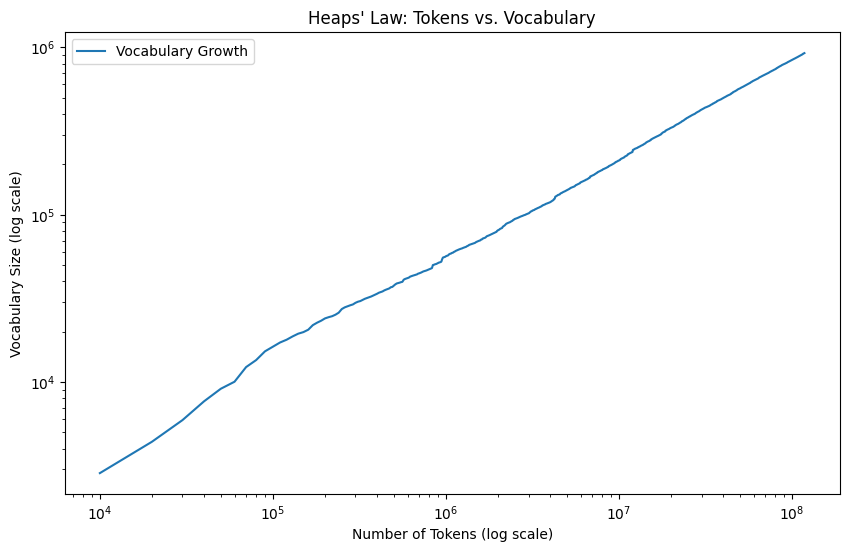

In [14]:
# Function to process and analyze the text in parallel
def process_text_and_analyze(corpus):
    with Pool() as pool:
        num_tokens, vocabulary, vocab_size = pool.apply(get_tokens_and_vocabulary, args=(corpus,))

    print(f"Number of tokens: {num_tokens}")
    print(f"Vocabulary size: {vocab_size}")

    word_frequencies, weighted_frequencies = weighted_freq_words(corpus)

    with Pool(processes=cpu_count) as pool:
        alpha, ranks, sorted_words = pool.apply(compute_zipf_law, args=(word_frequencies,))

    table = PrettyTable()
    table.field_names = ["Word", "Frequency", "Weighted Frequency", "Rank"]

    print("\nFirst 10 words by rank:")
    for i in range(10):
        word, freq = sorted_words[i]
        table.add_row([word, freq, round(weighted_frequencies[word], 4), ranks[i]])
    print(table)

    table.clear_rows()

    print("\nLast 10 words by rank:")
    for i in range(-10, 0, 1):
        word, freq = sorted_words[i]
        table.add_row([word, freq, round(weighted_frequencies[word], 4), ranks[i]])
    print(table)

    print(f"\nEstimated alpha value for Zipf's Law: {alpha:.4f}\n")

    plot_heaps_law(corpus, num_tokens)

# Process the text files in parallel and analyze
  # Ensure you have the list of JSON files here
corpus = parallel_process_corpus(file_names)

# Analyze the processed corpus
process_text_and_analyze(corpus)


In [15]:
type(preprocessing(json2text(json_files[0])))

NameError: name 'json_files' is not defined

In [ ]:
corpus[0]

In [ ]:
wrd_freq = weighted_freq_words(processed_txt)
w, a, f =compute_zipf_law(wrd_freq)

In [ ]:
a

In [ ]:
a

# Rough work